In [ ]:
"""
앙상블

머신러닝 앙상블이란 여러개의 머신러닝 모델을 이용해 최적의 답을 찾아내는 기법
-여러 모델을 이용하여 데이터를 학습하고, 모든 모델의 예측결과를 평균하여 예측

앙상블 기법의 종류
- 보팅: 투표를 통해 결과 도출
- 배깅: 샘플 중복 생성을 통해 결과 도출
- 부스팅: 이전 오차를 보완하면서 가중치 부여
- 스태킹: 여러 모델을 기반으로 예측된 결과를 통해 meta 모델이 다시 한번 예측
"""

In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')

np.set_printoptions(suppress = True)

In [3]:
from sklearn.datasets import load_boston

In [4]:
#데이터 로드 
data = load_boston()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['MEDV'] = data['target']

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('MEDV', 1), df['MEDV'], random_state=42)

In [6]:
#평가지표 만들기

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
mse_eval('LinearRegression', pred, y_test)

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
pred = ridge.predict(x_test)
mse_eval('Ridge(alpha=1)', pred, y_test)

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
pred = lasso.predict(x_test)
mse_eval('Lasso(alpha=0.01)', pred, y_test)

In [ ]:
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet.fit(x_train, y_train)
pred = elasticnet.predict(x_test)
mse_eval('ElasticNet(l1_ratio=0.8)', pred, y_test)    

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
elasticnet_pred = elasticnet_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Standard ElasticNet', elasticnet_pred, y_test)

In [ ]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

In [16]:
###앙상블 시작!! -- 보팅

In [17]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

In [18]:
single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet_pipeline', elasticnet_pipeline), 
    ('poly_pipeline', poly_pipeline)
]

In [19]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [20]:
voting_regressor.fit(x_train, y_train)

VotingRegressor(estimators=[('linear_reg', LinearRegression(n_jobs=-1)),
                            ('ridge', Ridge(alpha=1)),
                            ('lasso', Lasso(alpha=0.01)),
                            ('elasticnet_pipeline',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(alpha=0.1,
                                                         l1_ratio=0.2))])),
                            ('poly_pipeline',
                             Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures(include_bias=False)),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                       

In [21]:
voting_pred = voting_regressor.predict(x_test)

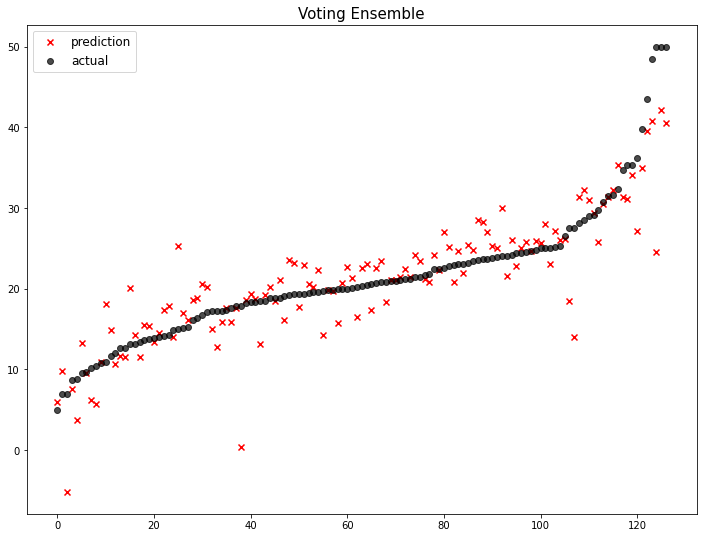

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1       Standard ElasticNet  22.694970
2            Ridge(alpha=1)  22.480476
3         Lasso(alpha=0.01)  22.210557
4          LinearRegression  22.098695
5           Voting Ensemble  20.474757
6           Poly ElasticNet  15.710492


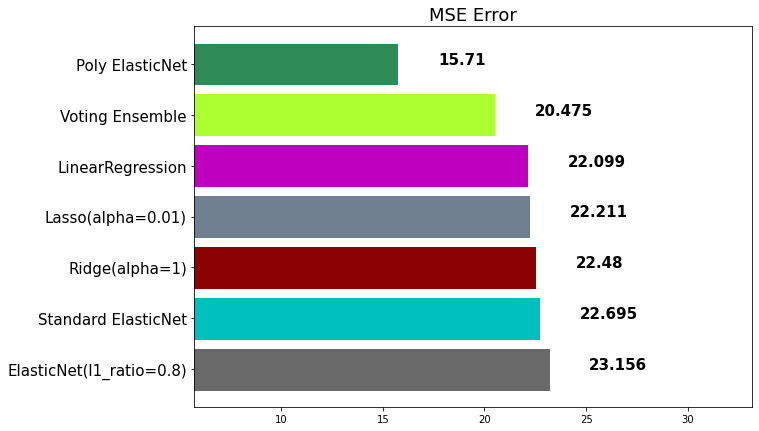

In [22]:
mse_eval('Voting Ensemble', voting_pred, y_test)

In [ ]:
#배깅
"""
여러개의 dataset 중첩을 허용하게 하여 샘플링하여 분할하는 방식

데이터 셋의 구성이 [1,2,3,4,5]로 되어 있다면,
1. group = [1,2,3]
2. group = [1,3,4]
3. group = [2,3,5]
"""

#보팅 vs 배깅
"""
보팅: 여러 알고리즘의 조합에 대한 앙상블
배깅: 하나의 단일 알고리즘에 대하여 여러 개의 샘플 조합으로 앙상블

대표적인 배깅 앙상블
1. RandomForest
2. Bagging"""

#RandomForest(배깅 기반)
"""
1. DecisionTree(트리)기반 Bagging 앙상블
2. 굉장히 인기있는 앙상블 모델
3. 사용성이 쉽고, 성능도 우수함
"""

In [24]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [25]:
rfr = RandomForestRegressor()
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

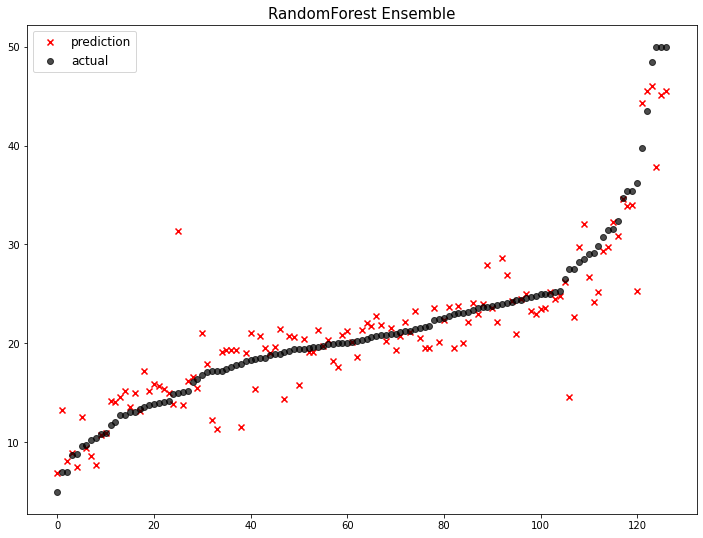

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1       Standard ElasticNet  22.694970
2            Ridge(alpha=1)  22.480476
3         Lasso(alpha=0.01)  22.210557
4          LinearRegression  22.098695
5           Voting Ensemble  20.474757
6           Poly ElasticNet  15.710492
7     RandomForest Ensemble  10.582475


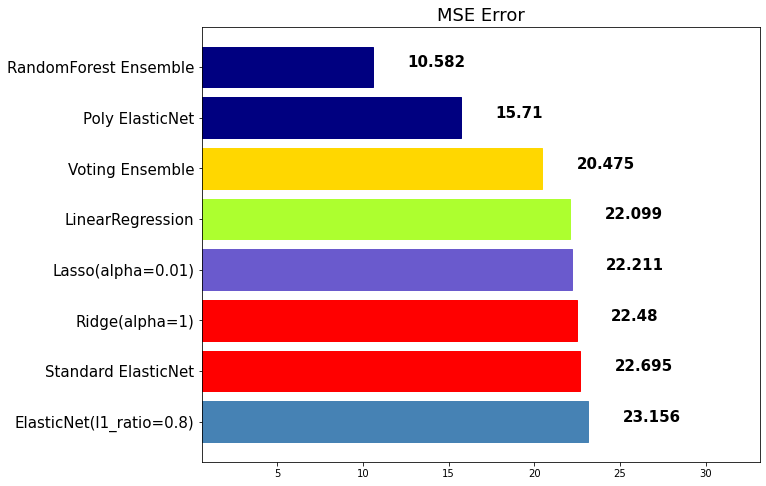

In [26]:
mse_eval('RandomForest Ensemble', rfr_pred, y_test)

In [ ]:
#주요 Hyperparameter
"""
random_state : 랜덤 시드 고정 값, 고정해두고 튜닝 할 것!
n_jobs : CPU 사용 갯수
max_depth : 깊어질 수 있는 최대 깊이, 과대 적합 방지용
n_estimators : 앙상블하는 트리의 갯수
max_features : 최대로 사용할 feature의 갯수 , 과대적합 방지용
min_samples_split: 트리가 분할할 때 최소 샘플의 갯수, 기본값 = 2, 과대 적합 방지용

!!튜닝을 할 땐 반드시 random_state 값을 고정 시켜야함
"""

In [28]:
rfr = RandomForestRegressor(random_state=42, n_estimators = 1000, max_depth=7, max_features=0.8)
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

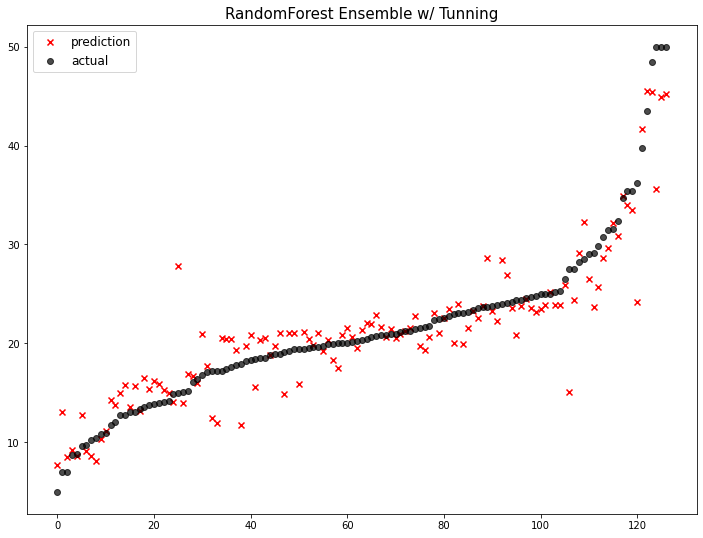

                              model        mse
0          ElasticNet(l1_ratio=0.8)  23.156236
1               Standard ElasticNet  22.694970
2                    Ridge(alpha=1)  22.480476
3                 Lasso(alpha=0.01)  22.210557
4                  LinearRegression  22.098695
5                   Voting Ensemble  20.474757
6                   Poly ElasticNet  15.710492
7             RandomForest Ensemble  10.582475
8  RandomForest Ensemble w/ Tunning  10.293518


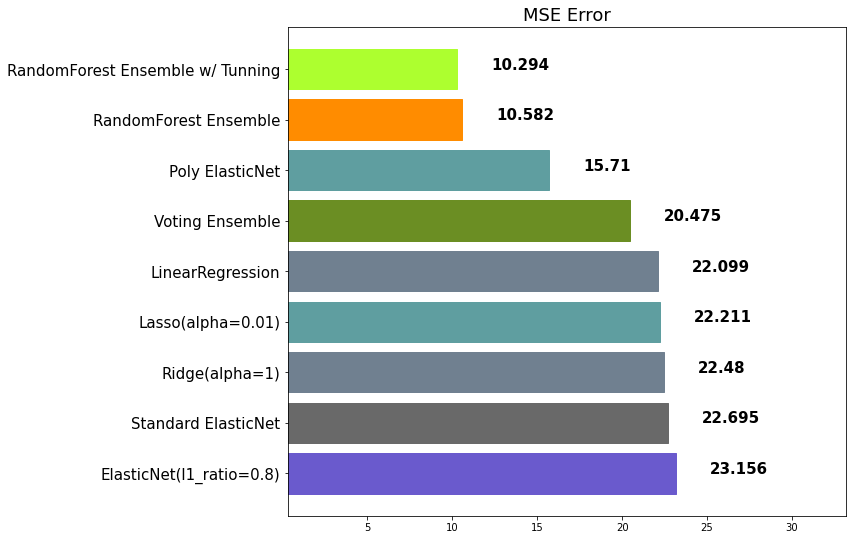

In [29]:
mse_eval('RandomForest Ensemble w/ Tunning', rfr_pred, y_test)

In [30]:
#부스팅 
"""
약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 가중치를 부여해 오차를 보완해 나가는 방식
장점:
    성능이 매우 우수하다(Lgbm, XGBoost)
단점:
    -부스팅 알고리즘의 특성상 계속 약점(오분류/잔차)을 보완하려고 하기 때문에 잘못된 레이블링이나 아웃라이어에 필요이상으로 민감
    -다른 앙상블 대비 학습시간이 오래 걸림
"""

#대표적인 부스팅 앙살블
"""
- AdaBoost
- GradientBoost
- LightGBM
- XGBoost
"""

'\n- AdaBoost\n- GradientBoost\n- LightGBM\n- XGBoost\n'